# Reading BODC data. Writing NC files with temperature along each mooring


** Summary: **
BODC data are provided as one file per instrument, i.e. per depth. This script reads all the netcdf files in a directory, extract the data per mooring, and then write a netcdf file with hourly temperature for each mooring.

** Problems/To do **
* Read models data and interpolate them on the same grid (time/depth)

** Notebook: ** BODC_data_writenc_mooring.ipynb

** Author: ** kariho40 27 dec 2015

** Changelog: **
* 20 Dec 2015 (jelt): get started from jelt script peanom.ipynb
* 27 Dec 2015 (kariho40): create a 2D array of temperature for each station, and interpolate on an hourly frequency


In [7]:
## Import the libraries

import numpy as np
import numpy.ma as ma
from scipy.io import netcdf
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt  # plotting
from sympy import * 
from __future__ import division

init_printing()  # for sympy
%matplotlib inline

## Personal librairies
import bodc_data_tools

######### Personal Paths #############
HOME = '/media/karen/NOC_data/OBS/BODC_FASTNEt_data/' #/home/karen/AMM60/'
CRUISE_DIR = HOME + 'D376_moored_hydrography/'
CSV_FILENAME = 'bodc_series_metadata_summary.csv'
WRITEDIR = '/media/karen/data1/AMM60/FASTNEt/BODC_fastnet/'


### Read the bodc data.

It needs the path to the csv file in entry (so we can use the same script for D376 and JC88)

In [8]:
csv_content=bodc_data_tools.readBodcCSV(CRUISE_DIR + CSV_FILENAME)
print 'There are',len(csv_content), 'instruments with reference numbers \n'

There are 118 instruments with reference numbers 



### For a unique lon/lat pair extract the depths and BODC references


In [9]:
# extract depth and BODC file names from the csv file, for a unique lon/lat pair
moorings = {}
for row in csv_content:
    loc = row['Latitude A'] + ',' + row['Longitude A']
    if moorings.has_key(loc):
        moorings[loc].append(row)
    else:
        moorings[loc] = [row]
        
print(moorings.keys())
for key in moorings:
    print('at ' + key + ' there are ' + str(len(moorings[key])) +' measurements')

# Check that the instruments are at fixed depths. Check that the max and min depths are equal for each instrument
for row in csv_content:
    if row['Series depth maximum (m)'] != row['Series depth minimum (m)']:
        print 'instruments are not all stationary. Depth variables need attention.'
        stop
print 'instruments are all stationary in depth. Depth variables will be OK'



['48.62975,-9.14678', '48.7665,-9.40287', '48.24348,-9.54593', '48.337,-9.4384', '48.64935,-9.10413']
at 48.62975,-9.14678 there are 39 measurements
at 48.7665,-9.40287 there are 25 measurements
at 48.24348,-9.54593 there are 25 measurements
at 48.337,-9.4384 there are 1 measurements
at 48.64935,-9.10413 there are 28 measurements
instruments are all stationary in depth. Depth variables will be OK


Coordinates of the moorings:
('-9.14678', '48.62975')
('-9.40287', '48.7665')
('-9.54593', '48.24348')
('-9.4384', '48.337')
('-9.10413', '48.64935')


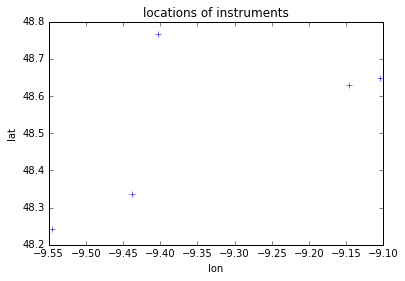

In [10]:
# Plot the locations of these data
fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (5.0, 5.0)

print('Coordinates of the moorings:')
for key in moorings:
    row = moorings[key][0]
    print(row['Longitude A'], row['Latitude A'])
    plt.plot(row['Longitude A'], row['Latitude A'],'b+')

    
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('locations of instruments')

plt.show()

Coordinates of the moorings:

ST1  ('-9.14678', '48.62975')

ST5  ('-9.40287', '48.7665')

ST2  ('-9.54593', '48.24348')

ST3  ('-9.4384', '48.337')

ST4  ('-9.10413', '48.64935')


### Data interpolation along a mooring line 


This bit loops on each mooring location, and:

* extracts temperature time and depth from all the moorings at this location

* orders them by depth

* masks the outliers and/or missing data

* Interpolates them on an hourly (or 'freq') axis

* writes a netcdf file per mooring containing the temperature function fo depth and time


48.62975,-9.14678
there are 39 instruments along this mooring
Interpolation on 17 days, i.e. 408 points
48.7665,-9.40287
there are 25 instruments along this mooring
Interpolation on 17 days, i.e. 408 points
48.24348,-9.54593
there are 25 instruments along this mooring
Interpolation on 16 days, i.e. 384 points
48.337,-9.4384
there are 1 instruments along this mooring
Interpolation on 15 days, i.e. 360 points
48.64935,-9.10413
there are 28 instruments along this mooring
Interpolation on 13 days, i.e. 312 points


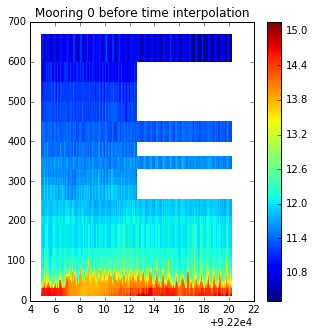

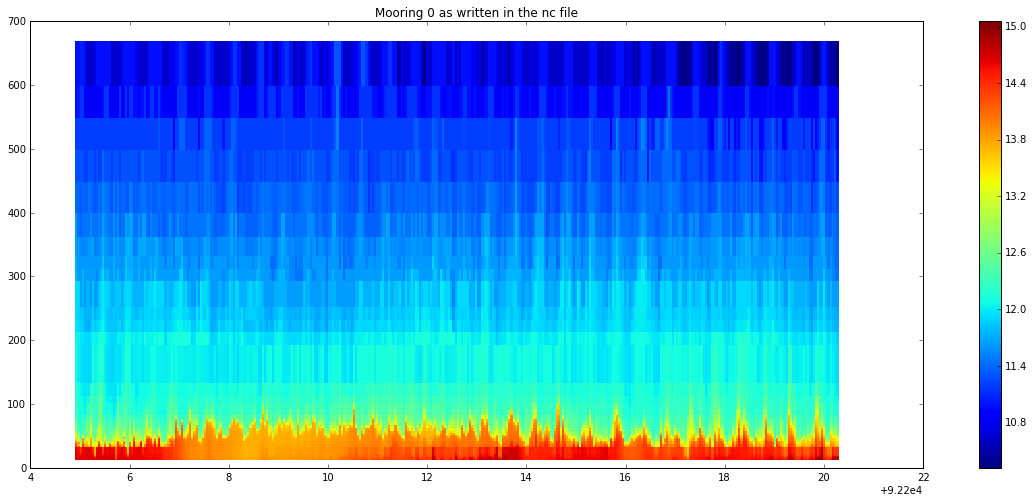

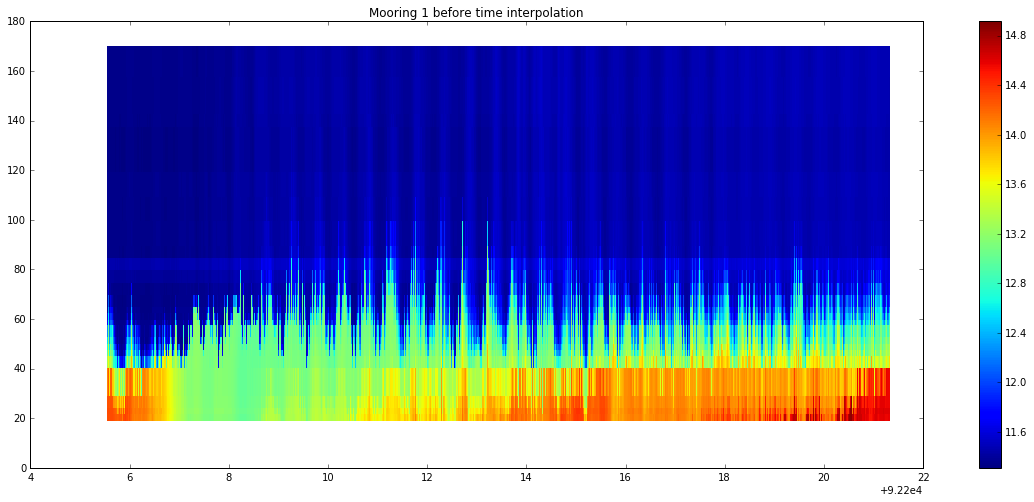

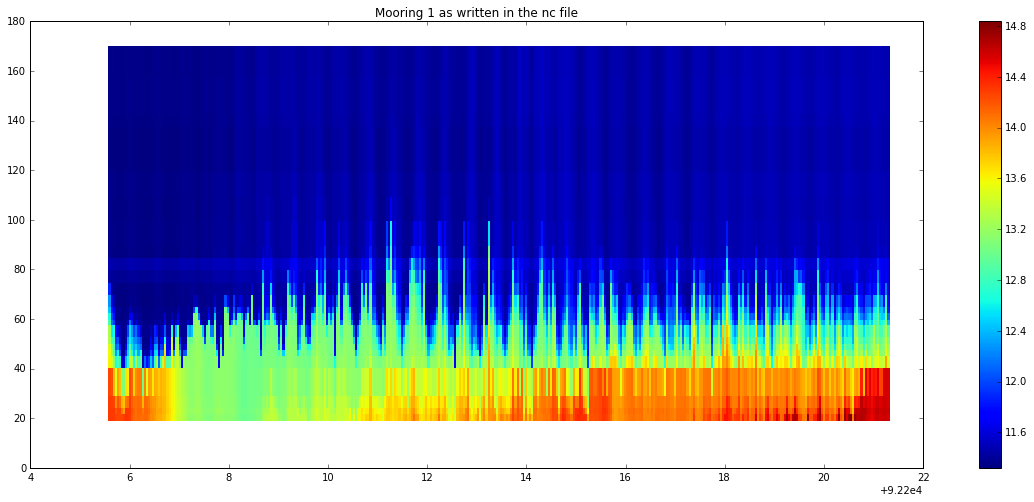

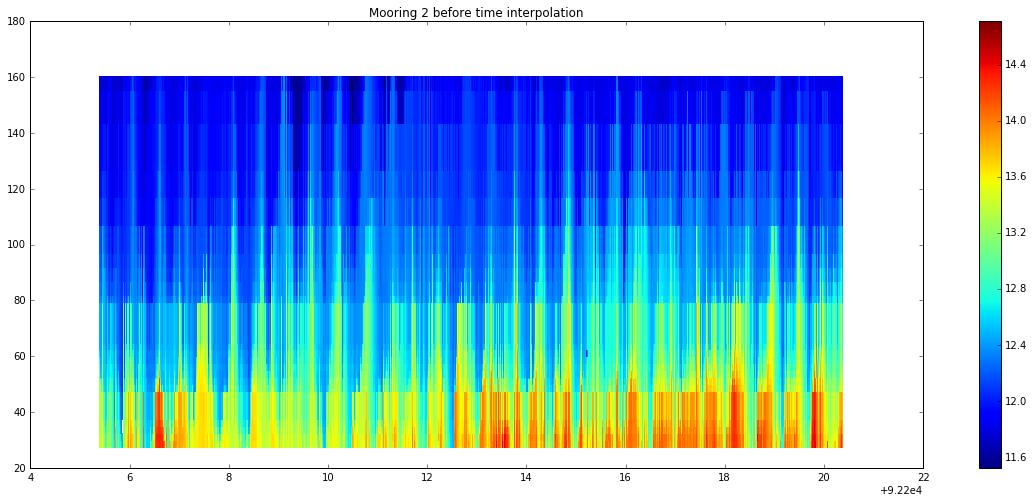

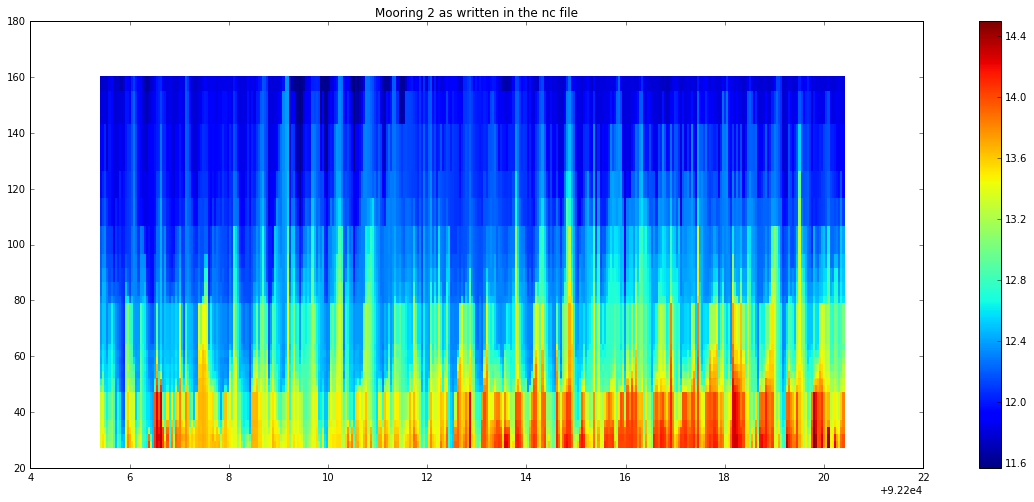

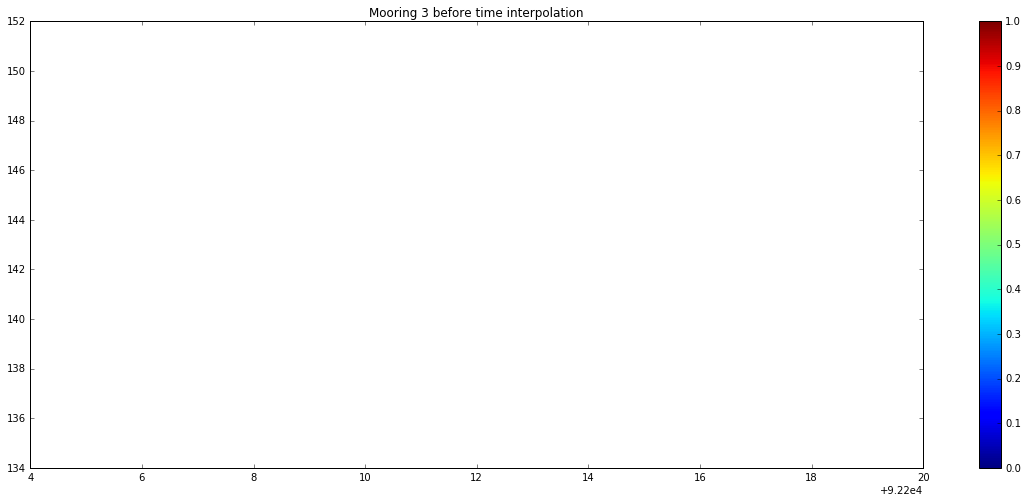

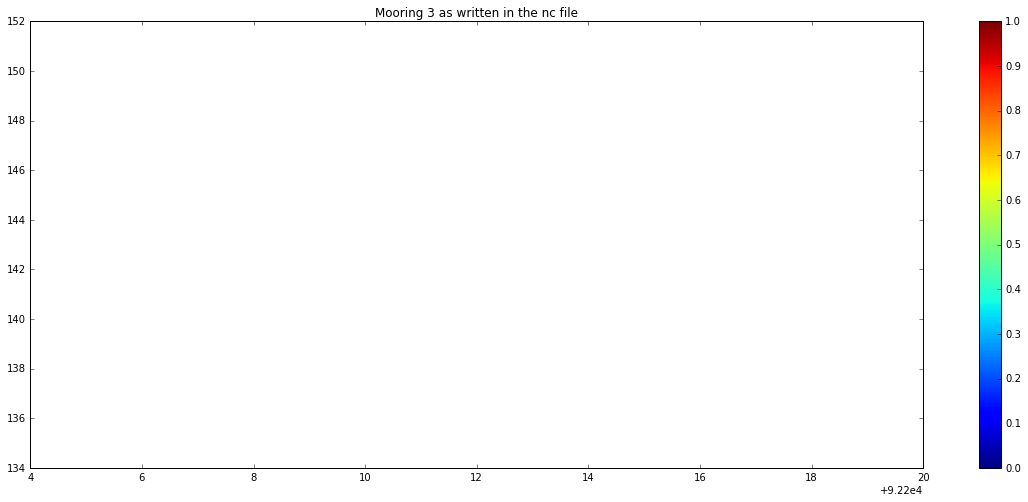

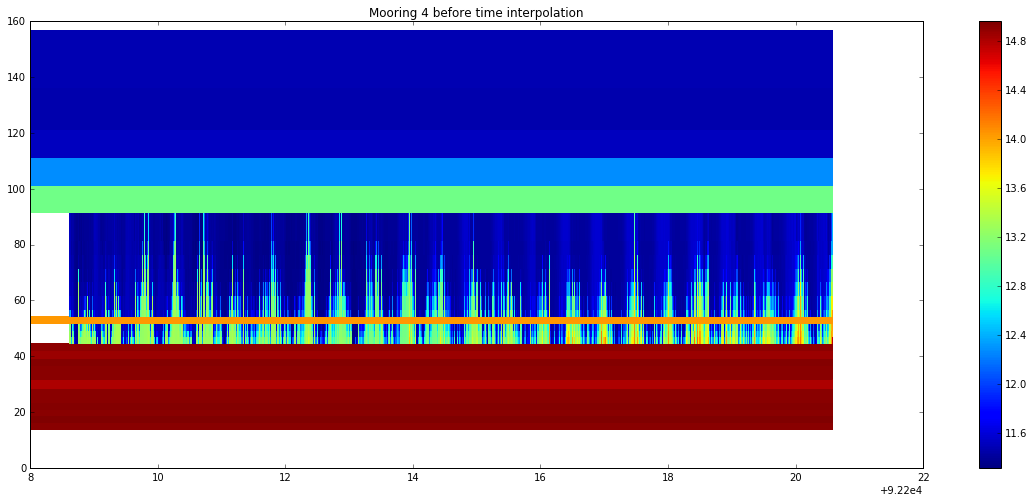

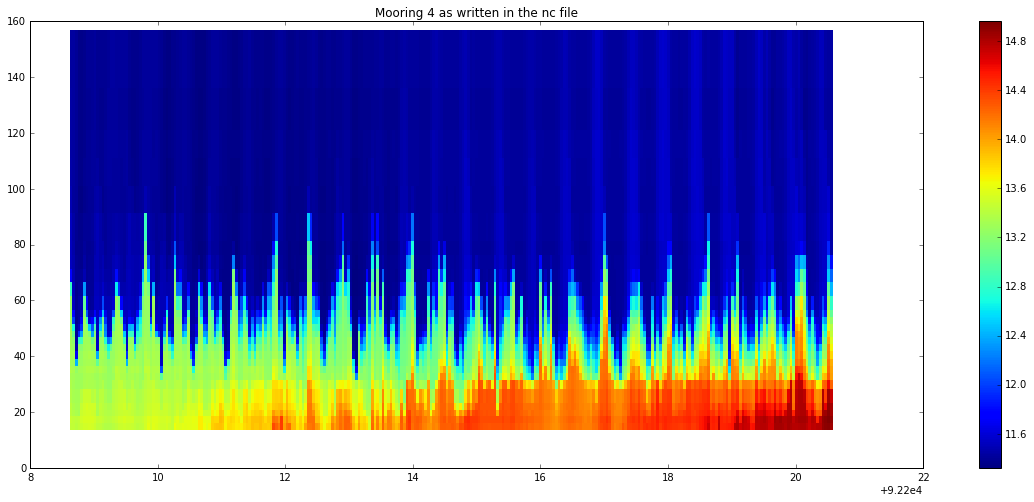

In [11]:
for location in range(len(moorings.values())):
    mooring = moorings.values()[location]
    coord = moorings.keys()[location]
    print(coord)
    [lat,lon] = coord.split(',')
    print('there are {} instruments along this mooring'.format(len(mooring)))
    
    # For each mooring, extract temperature, depth and time from the BODC files
    temperature, time, depth = bodc_data_tools.readBodcDataGivenLoc(mooring, CRUISE_DIR)
    
    # Plot the temperature time series. Beware, time axis is not the same for all instruments !
    fig, ax = plt.subplots(1,1)
    plt.rcParams['figure.figsize'] = (20.0, 8.0)
    plt.pcolormesh(time[0,:],depth[:],temperature)
    plt.colorbar()
    plt.title('Mooring ' + str(location) + ' before time interpolation')
    # Time-interpolation of the data (each instrument has its own frequency)
    # Freq = Time frequency for timeseries interpolation (1h for AMM60 comp)
    freq = 24
    temperature_taxis, taxis = bodc_data_tools.readBodcInterpTime(temperature,time,freq)
    fig, ax = plt.subplots(1,1)
    plt.rcParams['figure.figsize'] = (20.0, 8.0)
    plt.pcolormesh(taxis,depth,temperature_taxis)
    plt.colorbar()
    plt.title('Mooring '+ str(location)+' as written in the nc file')
    
    # Write NC
    ncname = WRITEDIR + 'mooring_' + str(location) + '.nc'
    bodc_data_tools.readBodcWriteNC(ncname,temperature_taxis,taxis,depth,lon,lat)


In [ ]:
print(type(lon))
print(lon)
toto=float(lon)
print(type(toto))